# Example: Optimal control of a PWA System by State-feedback Abstractions


This document reproduces [1, Example 2], which is a possible application of state-feedback transition system for the optimal control of piecewise-affine systems.
Consider a system $\mathcal{S}:=(\mathcal{X}, \mathcal{U},\rightarrow_F)$ with the transition function
$$
\begin{equation}
    \{A_{\psi(x)}x+B_{\psi(x)}u+g_{\psi(x)}\}\oplus\Omega_{\psi(x)}
\end{equation}
$$
where $\psi:\mathcal{X}\rightarrow\{1,\dots,N_p\}$ selects one of the $N_p$ subsystems defined by the matrices
$$
\begin{equation}
	A_1=\begin{bmatrix}
    1.01 & 0.3\\
    -0.1 & 1.01
\end{bmatrix}, ~B_1=\begin{bmatrix}
    1&0\\ 0 & 1
\end{bmatrix},~g_1=\begin{bmatrix}
-0.1\\-0.1
\end{bmatrix},
\end{equation}
$$
$A_2=A_1^\top,~ A_3=A_1,~B_2=B_3=B_1,~g_2=0$ and $g_3=-g_1$. These systems are three spiral sources with unstable equilibria at $x_{e1}=[-0.9635~~0.3654]^\top,~x_{e2}=0,$ and $x_{e3}=-x_{e1}$. We also define the additive-noise sets $\Omega_1=\Omega_2=\Omega_3=[-0.05,0.05]^2$, the control-input set $\mathcal{U}=[-0.5,0.5]^2$ and the state space $\mathcal{X}=[-2,2]^2$. The $N_p=3$ partitions of $\mathcal{X}$ are $\mathcal{X}_1= \{x\in\mathcal{X}~:~x_1\leq-1 \},~\mathcal{X}_3= \{x\in\mathcal{X}~:~x_1>1 \},$ and $\mathcal{X}_2=\mathcal{X}\setminus(\mathcal{X}_1\cup\mathcal{X}_3)$. The goal is to bring the state $x$ from the initial set $\mathcal{X}_0$ to a final set $\mathcal{X}_*$, while avoiding the obstacle $\mathcal{O}$, which are to be defined.

First, let us import
[StaticArrays](https://github.com/JuliaArrays/StaticArrays.jl),
[LinearAlgebra](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/),
[CDDLib](https://github.com/JuliaPolyhedra/CDDLib.jl),
[SDPA](https://github.com/jump-dev/SDPA.jl),
[Ipopt](https://github.com/jump-dev/Ipopt.jl), and
[JuMP](https://jump.dev/JuMP.jl/stable/). We also instantiate our optimizers and CDDLib.

In [1]:
using StaticArrays
using LinearAlgebra
using CDDLib
using SDPA, Ipopt, JuMP

opt_sdp = optimizer_with_attributes(SDPA.Optimizer, MOI.Silent() => true)
opt_ip = optimizer_with_attributes(Ipopt.Optimizer, MOI.Silent() => true)
lib = CDDLib.Library() #polyhedron lib

CDDLib.Library(:float)

We define now the of the polytope $\Omega$ with the disturbances and the input constraint set $\mathcal{U}$ and we imported the optimal control problem for this example, which is defined in the ```PWAsys.jl``` problem:

In [2]:
Wsz = 3 # `Wsz = 5` in [1]
Usz = 70 # upper limit on |u|, `Usz = 50` in [1]
dt = 0.01; # discretization step

include("../../../problems/PWAsys.jl")

const problem = PWAsys.problem(lib, dt, Usz)
const system = problem.system

n_x = size(system.resetmaps[1].A,1)
n_u = size(system.resetmaps[1].B,2)

W = Wsz*[-1 -1  1 1;
         -1  1 -1 1]*dt; # polytope of disturbances

Uaux = diagm(1:n_u)
U = [(Uaux.==i)./Usz for i in 1:n_u]; # matrices U_i

system.ext[:W] = W
system.ext[:U] = U

2-element Vector{Matrix{Float64}}:
 [0.014285714285714285 0.0; 0.0 0.0]
 [0.0 0.0; 0.0 0.014285714285714285]

notice that in [1] it was used `Wsz = 5` and `Usz = 50`. These, and other values were changed here to speed up the build time of the documentation.

Let us now get some more information about the problem as the dimension $n_x$ of the system

At this point we'll import Dionysos in order to solve our optimal control problem

In [3]:
using Dionysos
using Dionysos.Problem

Let us now define the state space $X$ within which we are searching for a optimal solution.

In [4]:
max_x = 2 # bound on |X|_∞
rectX = Dionysos.Utils.HyperRectangle(SVector(-max_x, -max_x), SVector(max_x, max_x));
rectU = rectX

Dionysos.Utils.HyperRectangle{StaticArraysCore.SVector{2, Int64}}([-2, -2], [2, 2])

This is state-space is defined by the `HyperRectangle rectX`. We also define a control space with the same bounds. This is done because, for a state-feedback abstraction, selecting a controller out of the set of controllers is the same as selecting a destination state out of the set of cells $\mathcal{X}_d$, given it's determinism.

To build this deterministic state-feedback abstraction in alternating simulation relation  with the system as described in [1, Lemma 1], a set of balls of radius 0.2 covering the state space is adopted as cells $\xi\in\mathcal{X}_d$. We assume that inside cells intersecting the boundary of partitions of $\mathcal{X}$ the selected piecewise-affine mode is the same all over its interior and given by the mode defined at its center. An alternative to this are discussed in [1]. Let us define the corresponding grid:

In [5]:
n_step = 2 #  n_step = 5 in [1]
X_origin = SVector(0.0, 0.0);
X_step = SVector(1.0/n_step, 1.0/n_step);
P = (1/n_x)*diagm((X_step./2).^(-2))

state_grid = Dionysos.Domain.GridEllipsoidalRectangular(X_origin, X_step, P, rectX)

Dionysos.Domain.GridEllipsoidalRectangular{2, Float64}([0.0, 0.0], [0.5, 0.5], [8.0 0.0; 0.0 8.0], Dionysos.Utils.HyperRectangle{StaticArraysCore.SVector{2, Int64}}([-2, -2], [2, 2]))

At this point, we instantiate the optimizer provided in Dionysos that creates ellipsoidal-based
abstractions `OptimizerEllipsoids`

In [6]:
using JuMP
optimizer = MOI.instantiate(Abstraction.OptimizerEllipsoids) #

MOI.set(optimizer, MOI.RawOptimizerAttribute("problem"), problem)
MOI.set(optimizer, MOI.RawOptimizerAttribute("state_grid"), state_grid)
MOI.set(optimizer, MOI.RawOptimizerAttribute("sdp_solver"), opt_sdp)
MOI.set(optimizer, MOI.RawOptimizerAttribute("ip_solver"), opt_ip)

MathOptInterface.OptimizerWithAttributes(Ipopt.Optimizer, Pair{MathOptInterface.AbstractOptimizerAttribute, Any}[MathOptInterface.Silent() => true])

and run it to build the state-feedback abstraction and solve the optimal control problem by through Dijkstra's algorithm [2, p.86].

In [7]:
using Suppressor
@suppress  begin # this is a workaround to supress the undesired output of SDPA
      MOI.optimize!(optimizer)
end
contr = MOI.get(optimizer, MOI.RawOptimizerAttribute("controller"))
symmodel = MOI.get(optimizer, MOI.RawOptimizerAttribute("symmodel"))
transitionCost = MOI.get(optimizer, MOI.RawOptimizerAttribute("transitionCost"))
transitionKappa = MOI.get(optimizer, MOI.RawOptimizerAttribute("transitionKappa"))
lyap_fun = MOI.get(optimizer, MOI.RawOptimizerAttribute("lyap_fun"));

## Simulation
Now let us get the Q_aug matrix defining the stage cost $\mathcal{J}(x,u) = ||Q^{1/2} \cdot [x; u ; 1]||^2_2$

In [8]:
Q_aug = Dionysos.Control.get_full_psd_matrix(problem.transition_cost[1][1])

5×5 Matrix{Float64}:
 0.0001  0.0     0.0     0.0     0.0
 0.0     0.0001  0.0     0.0     0.0
 0.0     0.0     0.0001  0.0     0.0
 0.0     0.0     0.0     0.0001  0.0
 0.0     0.0     0.0     0.0     0.0

Let us initialize variables used in our simulation and now we will simulate one trajectory of the system.

In [9]:
x0 = Vector(problem.initial_set); # initial condition

domainX = symmodel.Xdom

ϕ(x) = findfirst(m -> (x ∈ m.X), system.resetmaps) # returns pwa mode for a given x

K = typeof(problem.time) == Infinity ? 100 : problem.time; #max num of steps
x_traj = zeros(n_x,K+1);
u_traj = zeros(n_u,K+1);
x_traj[:,1] = x0;
state_traj = []

k = 1; #iterator
costBound = 0;
costTrue = 0;
currState = Dionysos.Symbolic.get_all_states_by_xpos(symmodel,Dionysos.Domain.crop_to_domain(domainX,Dionysos.Domain.get_all_pos_by_coord(state_grid,x_traj[:,k])))
push!(state_traj,currState);

Xinit = Dionysos.Domain.DomainList(state_grid) # set of initial cells
Dionysos.Domain.add_coord!(Xinit, problem.initial_set)

Xfinal = Dionysos.Domain.DomainList(state_grid) # set of target cells
Dionysos.Domain.add_coord!(Xfinal, Vector(problem.target_set))

Xobstacles = Dionysos.Domain.DomainList(state_grid) # set of obstacle cells
for o in system.ext[:obstacles]
      Dionysos.Domain.add_set!(Xobstacles, o, Dionysos.Domain.OUTER)
end

initlist = [Dionysos.Symbolic.get_state_by_xpos(symmodel, pos) for pos in Dionysos.Domain.enum_pos(Xinit)];
finallist = [Dionysos.Symbolic.get_state_by_xpos(symmodel, pos) for pos in Dionysos.Domain.enum_pos(Xfinal)];
obstaclelist = [Dionysos.Symbolic.get_state_by_xpos(symmodel, pos) for pos in Dionysos.Domain.enum_pos(Xobstacles)];

and proceed with the simulation

In [10]:
println("started at: $(currState)")
while (currState ∩ finallist) == [] && k ≤ K # While not at goal or not reached max iter
      println("k: $(k)")
      next_action = nothing
      for action in contr.data
            if (action[1] ∩ currState) ≠ []
                  next_action = action
                  println("next action: $(next_action)")
            end
      end
      println("cm: $(Dionysos.Domain.get_coord_by_pos(state_grid, Dionysos.Symbolic.get_xpos_by_state(symmodel, next_action[2])))")

      c = Dionysos.Domain.get_coord_by_pos(state_grid, Dionysos.Symbolic.get_xpos_by_state(symmodel, next_action[1]))
      println("c: $(c)")


      u_traj[:,k] = transitionKappa[next_action]*vcat(x_traj[:,k]-c,1.0)
      println("x: $(x_traj[:,k])")
      println("u: $(u_traj[:,k])")

      global costBound = costBound + transitionCost[next_action]
      xk_aug = vcat(x_traj[:,k], u_traj[:,k],1.0)
      global costTrue += xk_aug'Q_aug*xk_aug


      m = ϕ(c)

      w = (2*(rand(2).^(1/4)).-1).*W[:,1]

      x_traj[:,k+1] = system.resetmaps[m].A*x_traj[:,k]+system.resetmaps[m].B*u_traj[:,k] + system.resetmaps[m].c + w

      global k += 1;
      global currState =  Dionysos.Symbolic.get_all_states_by_xpos(symmodel,Dionysos.Domain.crop_to_domain(domainX,Dionysos.Domain.get_all_pos_by_coord(state_grid,x_traj[:,k])));
      push!(state_traj,currState)
      println("Arrived in: $(currState): $(x_traj[:,k])")
end

println("Goal set reached")
println("Guaranteed cost:\t $(costBound)")
println("True cost:\t\t $(costTrue)")

started at: [45]
k: 1
next action: (45, 21)
cm: [1.5, -2.0]
c: [2.0, -2.0]
x: [2.0, -2.0]
u: [0.13854652320202732, 5.936346614385097]
Arrived in: [21]: [1.4980736608493286, -2.0581964724763653]
k: 2
next action: (21, 15)
cm: [0.5, -2.0]
c: [1.5, -2.0]
x: [1.4980736608493286, -2.0581964724763653]
u: [-30.95048808035843, 9.901350337772225]
Arrived in: [15, 63]: [0.6818226999910807, -2.0486316213527975]
k: 3
next action: (15, 41)
cm: [0.5, -1.5]
c: [0.5, -2.0]
x: [0.6818226999910807, -2.0486316213527975]
u: [-22.19266882659071, 29.30670967643595]
Arrived in: [41]: [0.6437737322585854, -1.58308574533497]
k: 4
next action: (41, 26)
cm: [0.0, -1.5]
c: [0.5, -1.5]
x: [0.6437737322585854, -1.58308574533497]
u: [-61.22343692553457, -13.020319985222779]
Arrived in: [26, 41]: [0.18743089783389313, -1.5636413803770355]
k: 5
next action: (41, 26)
next action: (26, 50)
cm: [-0.5, -1.0]
c: [0.0, -1.5]
x: [0.18743089783389313, -1.5636413803770355]
u: [-63.24434020450668, 45.5527516450448]
Arrived in: 

Finally let us visualize the results. Let us plot the transitions in the state-feedback abstraction

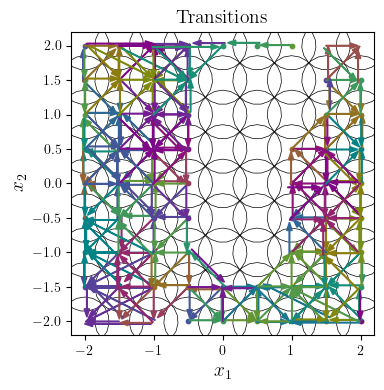

In [11]:
using PyPlot
include("../../../src/utils/plotting/plotting.jl")



PyPlot.rc("text",usetex=true)
PyPlot.rc("font",family="serif")
PyPlot.rc("font",serif="Computer Modern Roman")
PyPlot.rc("text.latex",preamble="\\usepackage{amsfonts}")


fig = PyPlot.figure(tight_layout=true, figsize=(4,4))

ax = PyPlot.axes(aspect = "equal")
ax.set_xlim(rectX.lb[1]-0.2,rectX.ub[1]+0.2)
ax.set_ylim(rectX.lb[2]-0.2,rectX.ub[2]+0.2)

vars = [1, 2];



Plot.domain_ellips!(ax, vars, P, domainX, fc = "none", ew = 0.5)


d=0.02;
for t in symmodel.autom.transitions.data
      if isempty(t ∩ obstaclelist)
            offset = randn(1)[1]*d
            arrow_x, arrow_y = Dionysos.Domain.get_coord_by_pos(state_grid,Dionysos.Symbolic.get_xpos_by_state(symmodel,t[2]))
            aux = (Dionysos.Domain.get_coord_by_pos(state_grid,Dionysos.Symbolic.get_upos_by_symbol(symmodel,t[1]))-[arrow_x, arrow_y])
            arrow_dx, arrow_dy = aux*(norm(aux)-0.15)/norm(aux)
            color = (abs(0.6*sin(t[1])), abs(0.6*sin(t[1]+2π/3)), abs(0.6*sin(t[1]-2π/3)));
            if t[1]==t[2]
                  PyPlot.scatter(arrow_x, arrow_y, s=10, fc=color, ec=color)
            else
                  PyPlot.arrow(arrow_x+offset, arrow_y+offset, arrow_dx, arrow_dy,fc=color, ec=color,width=0.01, head_width=.08)
            end
      end

end
PyPlot.xlabel("\$x_1\$", fontsize=14)
PyPlot.ylabel("\$x_2\$", fontsize=14)
PyPlot.title("Transitions", fontsize=14)
gcf()

Then we plot a colormap with the Lyapunov-like function $v(x)$ and the simulated trajectory in blue.

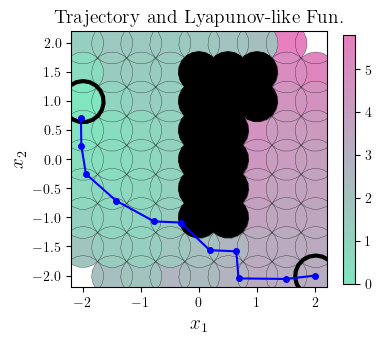

In [12]:
fig = PyPlot.figure(tight_layout=true, figsize=(4,4))

ax = PyPlot.axes(aspect = "equal")
ax.set_xlim(rectX.lb[1]-0.2,rectX.ub[1]+0.2)
ax.set_ylim(rectX.lb[2]-0.2,rectX.ub[2]+0.2)

vars = [1, 2];

lyap_max = max(filter(isfinite,getfield.([lyap_fun...],:second))...)

cost_ordered = reverse(sort(hcat([ (lyap,state) for (state,lyap) in lyap_fun]...),dims=2))
for (lyap,state) in cost_ordered
      aux_dom = Dionysos.Domain.DomainList(state_grid)
      x_aux = Dionysos.Domain.get_coord_by_pos(state_grid, Dionysos.Symbolic.get_upos_by_symbol(symmodel,state))
      Dionysos.Domain.add_coord!(aux_dom, x_aux)
      if (lyap ≠ Inf)
            Plot.domain_ellips!(ax, vars, P, aux_dom,  ew = 0, fc = (0.4*lyap/lyap_max+0.5, 0.4*(lyap_max-lyap)/lyap_max+0.5, 0.75), fa=1.0)
      end

end
for (lyap,state) in cost_ordered
      aux_dom = Dionysos.Domain.DomainList(state_grid)
      x_aux = Dionysos.Domain.get_coord_by_pos(state_grid, Dionysos.Symbolic.get_upos_by_symbol(symmodel,state))
      Dionysos.Domain.add_coord!(aux_dom, x_aux)
      if (lyap == Inf)
            Plot.domain_ellips!(ax, vars, P, aux_dom, fc = "none", ew = 0.2)
      else
            Plot.domain_ellips!(ax, vars, P, aux_dom, fc = "none", fa=1.0, ew = 0.2)
      end

end
Plot.domain_ellips!(ax, vars, P, Xinit, fc = "none", ew = 3)
Plot.domain_ellips!(ax, vars, P, Xfinal, fc = "none", ew = 3)

Plot.domain_ellips!(ax, vars, P, Xobstacles, fc = "black", ew = 0.5, fa=1.0)

PyPlot.plot(x_traj[1,1:k],x_traj[2,1:k],"bo-",markersize=4)
cmap = PyPlot.ColorMap("mycolor",hcat([0.0,0.8,0.5,0.5],[0.8,0.0,0.5,0.5])');
PyPlot.colorbar(PyPlot.ScalarMappable(norm=PyPlot.cm.colors.Normalize(vmin=0, vmax=lyap_max),cmap=cmap),shrink=0.7)

PyPlot.xlabel("\$x_1\$", fontsize=14)
PyPlot.ylabel("\$x_2\$", fontsize=14)
PyPlot.title("Trajectory and Lyapunov-like Fun.", fontsize=14)
gcf()

We recall that, to speed up the build time of this documentation, some values were modified in comparison with [1, Example 2]. To obtain the same figures use `Usz = 50`, `Wsz = 5` and `n_step = 5`.

## References

1. L. N. Egidio, T. Alves Lima, R. M. Jungers, "State-feedback Abstractions for Optimal Control of Piecewise-affine Systems", IEEE 61st Conference on Decision and Control (CDC), 2022, accepted.
1. D. Bertsekas, "Dynamic programming and optimal control". Volume I, Athena scientific, 2012.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*